# Electrostatic Field Fluctuations

Text retrieved from [1]: *Although the plasma is in thermal equilibrium, there are constant exchanges of energy
between the sheets and the (electrostatic) waves propagating inside the plasma. This
leads to the appearance of electrostatic fluctuations, with an average power spectrum
that follows* [2]:

$$
\frac{\langle E^2(k)\rangle}{8\pi}\ = \frac{k_BT}{2L\left(1 + k^2\lambda_D^2\right)}
$$

*where $k$ represents the wave vector, $k_B$ the Boltzmann constant, $T$ the plasma
temperature $\left(k_B T = m v_{th}^2\right)$, and $\langle \cdot \rangle$ the time average.*

In this notebook we recover this phenomena by computing the time average of the power spectrum of the electrostatic field for a thermal plasma (sheet velocities initialized using a normal distribution with standard deviation ~$v_{th}$).

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.3 <br>
[2] J. Dawson, Reviews of modern physics 55 403 - See pp. 420


In [1]:
import os
import sys
import jax
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('../..')
from sheet_model.utils import get_relaxation_time, get_kEfield, get_dx_eq, get_x_eq
from gns.simulator import SMGNS

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

### Initial Conditions

In [2]:
# system properties
n_sheets = 1000
boundary = 'reflecting'

# aux variables
x_eq = get_x_eq(n_sheets)
dx_eq = get_dx_eq(n_sheets)

# initial velocity distribution std 
# ! it is not v_th, part of the energy will be deposited in the fields
v_std_0 = 5.4 # [dx_eq w_p]

# for reproducibility
np.random.seed(42)

# intial x/v values
x_0 = np.copy(x_eq)
v_0 = np.random.normal(0, v_std_0, n_sheets) * dx_eq

### Initialize GNS

In [3]:
gns = SMGNS('../../models/final/dt1e-1/4', boundary)

Simulator Info
   GNN model: ../../models/final/dt1e-1/4
   boundary: reflecting
   L: 1
   dt_train: 0.1
   Training Dataset
      L: 1.0
      augment_t: True
      augment_x: True
      boundary: periodic
      data_folder: data/dataset/train/10/periodic/
      dt_simulator: 0.01
      dt_undersample: 10
      mode: crossings
      n_neighbors: 1
      n_sheets: 10
      save_folder: data/processed_temp/train/dt1e-1
      var_target: dvdt
      w_size: 1


### Run Simulation

In [4]:
t_max = 200

X, V, _ , E = gns.pred_rollout(x_0,
                               v_0,
                               x_eq,
                               t_max=t_max,
                               verbose=True,
                               track_sheets=False,
                               n_guards=4,
                               np_=np)

print('dE/E0:', (E[-1]-E[0])/E[0])

  0%|          | 0/2000 [00:00<?, ?it/s]

dE/E0: 0.0025707234


### Compute Correct $\lambda_D$

In [5]:
# lambda_d == v_th in our units
# use last step to compute
lambda_d = np.std(V[-1]/ dx_eq)

# only sample once every t_relaxation (t_relax used here is overestimated)
t_relax = get_relaxation_time(lambda_d)
t_min = t_relax
t = np.arange(t_min, t_max, t_relax/4)
it = t / gns.dt_train
it = it.astype(np.int64)


# kb * T = v_th**2 * m = lambda_d**2 * w_p ** 2 * m, 
# m = 1, w_p = 1
kbT = lambda_d**2
print(f'lambda_d: {lambda_d:.2f}')
print(f'nkbT: {kbT:.2f}')
print(f't_relax: {t_relax:.2f}')

lambda_d: 5.09
nkbT: 25.90
t_relax: 12.76


## Compute E-field power spectrum

In [6]:
def get_time_average_kEf2(X, nx, dx_eq):
        
    kEf2 = []
    for i in range(len(X)):
        kEf = get_kEfield(X[i], nx, dx_eq)[1]
        kEf2.append(kEf**2)
        
    kEf2 = np.mean(kEf2, axis=0)
        
    return kEf2

def theoretical_curve(x):
    return 1 / (1 + x**2)

# number of grid points for E-field
nx = 200000

# power spectrum sheet model @ t = tmax
k, kEf = get_kEfield(X[it[-1]], nx, dx_eq)
kEf2 = kEf**2
# power spectrum sheet model averaged over time (sampled once every t_relax)
kEf2_avg = get_time_average_kEf2(X[it], nx, dx_eq)

x = k * lambda_d

# In CGS units
# E(k=0) = 8*pi*kbT / 2L
# in our units, the 4*pi disappears, and L = n_sheets [dx_eq]
kEf2_0 = kbT / n_sheets

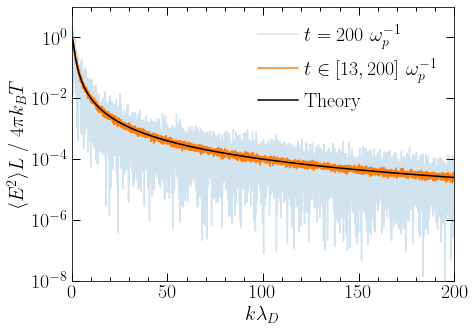

In [7]:
plt.figure()
plt.plot(x, kEf2 / kEf2_0 , '-', ms=0.5, alpha=0.2, label=f"$t = {t_max:.0f} \ \omega^{{-1}}_p$")
plt.plot(x, kEf2_avg / kEf2_0, label=f"$t \in [{t_min:.0f}, {t_max:.0f}] \ \omega^{{-1}}_p$")
plt.plot(x, theoretical_curve(x), label='Theory', color='k')
plt.xlim(0, np.max(x))
plt.yscale('log')
plt.ylabel(r'$\langle E^2 \rangle L$ / $4 \pi k_B T$')
plt.xlabel('$k\lambda_D$')
plt.xlim(0,200)
plt.ylim(1e-8,10)
leg = plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../img/efield_fluctuations', dpi=300)
plt.show()